# Explainability of Machine Learning Models  
## Comparing SHAP and Permutation Feature Importance


## 1. Introduction
This project investigates explainability techniques for machine learning models predicting household appliance energy consumption. The main goal is to compare Permutation Feature Importance (PFI) and SHAP explanations and evaluate whether they provide consistent insights into model behavior.


## 2. Dataset and Feature Engineering
In this section, the dataset is explored and relevant temporal features are extracted from the timestamp. The goal is to transform raw time information into meaningful predictors such as hour of the day and weekend indicators.


In [1]:
!pip install shap xgboost -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor
import shap

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("/content/drive/MyDrive/strojno/KAG_energydata_complete.csv")
df.info()
df.describe().T
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

,0
date,0
Appliances,0
lights,0
T1,0
RH_1,0
T2,0
RH_2,0
T3,0
RH_3,0
T4,0


In [3]:
df['date'] = pd.to_datetime(df['date'])
print(df['date'].min(), " -> ", df['date'].max())
df[['date']].head()


2016-01-11 17:00:00  ->  2016-05-27 18:00:00


,date
0,2016-01-11 17:00:00
1,2016-01-11 17:10:00
2,2016-01-11 17:20:00
3,2016-01-11 17:30:00
4,2016-01-11 17:40:00


In [4]:
df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.dayofweek      # 0=pon, 6=ned
df['month'] = df['date'].dt.month
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
df['day'] = df['date'].dt.day


In [5]:
df[['date','hour','dayofweek','month','is_weekend']].head()


,date,hour,dayofweek,month,is_weekend
0,2016-01-11 17:00:00,17,0,1,0
1,2016-01-11 17:10:00,17,0,1,0
2,2016-01-11 17:20:00,17,0,1,0
3,2016-01-11 17:30:00,17,0,1,0
4,2016-01-11 17:40:00,17,0,1,0


In [6]:
df = df.drop(columns=['date'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 non-null  float64
 19  RH_9

In [7]:
df.columns


Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2', 'hour', 'dayofweek', 'month', 'is_weekend',
       'day'],
      dtype='object')

In [8]:
X = df.drop(columns=['Appliances'])
y = df['Appliances']

print(X.shape, y.shape)


(19735, 32) (19735,)


Since the data are time-dependent, a time-based split was used instead of a random one. The model was trained on earlier observations and tested on more recent ones in order to avoid data leakage and to simulate a realistic real-world deployment scenario.

In [9]:
split_idx = int(len(df) * 0.8)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (15788, 32) (15788,)
Test : (3947, 32) (3947,)


In [10]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


## 3. Model Training and Evaluation
Two tree-based regression models are trained: Random Forest and XGBoost. A time-based train-test split is used to simulate real-world forecasting. Model performance is evaluated using MAE, RMSE, and R².


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

rf_log = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_log.fit(X_train, y_train_log)
pred_log = rf_log.predict(X_test)

pred_rf = np.expm1(pred_log)

mae = mean_absolute_error(y_test, pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, pred_rf))
r2 = r2_score(y_test, pred_rf)

print("RF MAE :", mae)
print("RF RMSE:", rmse)
print("RF R2  :", r2)


RF MAE : 90.86302732223842
RF RMSE: 121.87610133852839
RF R2  : -0.7922006623635502


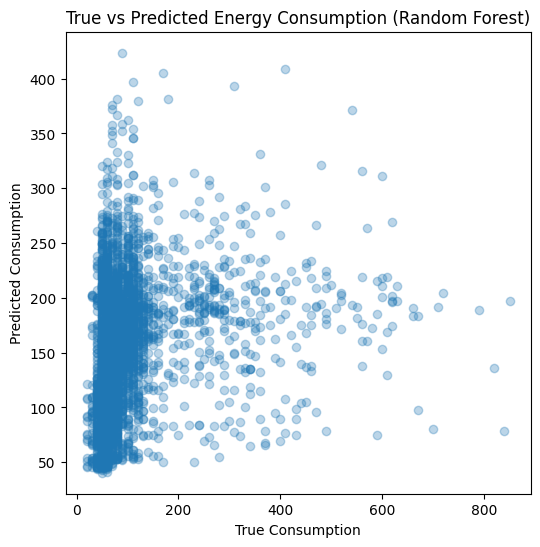

In [24]:

pred_rf = np.expm1(pred_log)

plt.figure(figsize=(6,6))
plt.scatter(np.expm1(y_test_log), pred_rf, alpha=0.3)
plt.xlabel("True Consumption")
plt.ylabel("Predicted Consumption")
plt.title("True vs Predicted Energy Consumption (Random Forest)")
plt.show()


The scatter plot for Random Forest shows that the model captures overall consumption patterns but struggles to predict extreme spikes, similar to XGBoost, though with slightly larger deviations.

After the initial training of the Random Forest model, very poor results were obtained (negative R²), indicating that the model failed to generalize well to the test set. An analysis of the target variable distribution revealed that energy consumption is highly skewed, with many low values and rare but very large spikes.

For this reason, a logarithmic transformation of the target variable was applied to reduce the influence of extreme values and stabilize the variance. After the transformation, the model showed a significantly lower average error (MAE and RMSE were nearly halved), although R² remained low. This suggests that the model successfully captures typical consumption patterns but still struggles with rare, very large spikes in energy usage.

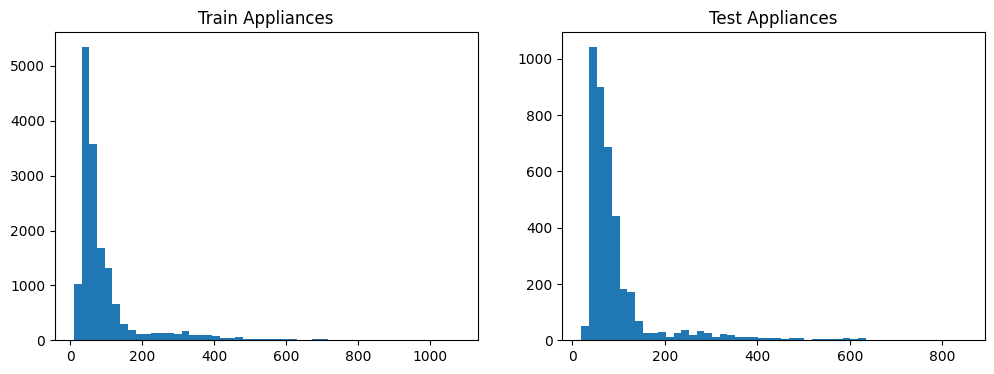

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(y_train, bins=50)
plt.title("Train Appliances")

plt.subplot(1,2,2)
plt.hist(y_test, bins=50)
plt.title("Test Appliances")

plt.show()


In [13]:
xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train_log)

pred_log = xgb.predict(X_test)
pred_xgb = np.expm1(pred_log)

mae = mean_absolute_error(y_test, pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, pred_xgb))
r2 = r2_score(y_test, pred_xgb)

print("XGB (log) MAE :", mae)
print("XGB (log) RMSE:", rmse)
print("XGB (log) R2  :", r2)

XGB (log) MAE : 77.82049560546875
XGB (log) RMSE: 105.12782398109455
XGB (log) R2  : -0.3334749937057495


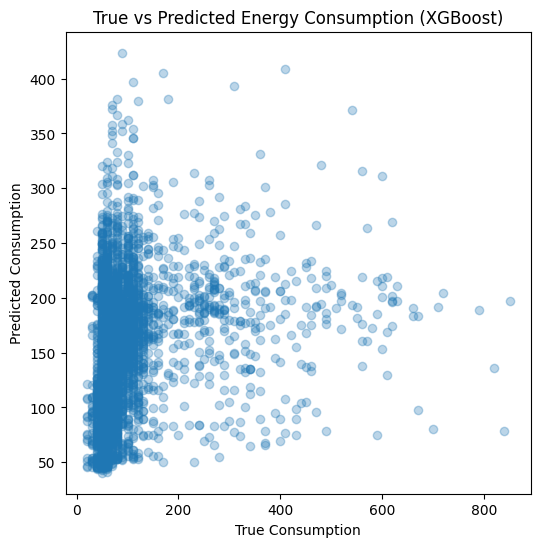

In [23]:
plt.figure(figsize=(6,6))
plt.scatter(np.expm1(y_test_log), pred_xgb, alpha=0.3)
plt.xlabel("True Consumption")
plt.ylabel("Predicted Consumption")
plt.title("True vs Predicted Energy Consumption (XGBoost)")
plt.show()


The scatter plot shows that the model captures general consumption trends but struggles with rare high-consumption spikes.

After applying a logarithmic transformation to the target variable, model performance improved significantly. The XGBoost model achieved a lower mean absolute error and lower RMSE compared to the Random Forest, indicating a better ability to capture typical energy consumption patterns. Although the R² score remained low due to the strong skewness of the distribution and the presence of rare extreme values, the models now demonstrate a reasonable level of predictive power and are suitable for further explainability analysis.

## 4. Permutation Feature Importance (PFI)
Permutation Feature Importance is used to measure how much each feature contributes to model performance. Feature importance is analyzed for both Random Forest and XGBoost models.


In [14]:
from sklearn.inspection import permutation_importance

pfi_rf = permutation_importance(rf_log, X_test, y_test_log, n_repeats=10, random_state=42, n_jobs=-1)
pfi_xgb = permutation_importance(xgb, X_test, y_test_log, n_repeats=10, random_state=42, n_jobs=-1)


In [15]:
rf_importances = pd.Series(pfi_rf.importances_mean, index=X_test.columns).sort_values(ascending=False)
xgb_importances = pd.Series(pfi_xgb.importances_mean, index=X_test.columns).sort_values(ascending=False)

rf_importances.head(10)


,0
hour,5.480530e-01
RH_4,3.038551e-02
RH_8,2.271260e-02
T8,1.650101e-02
lights,1.545721e-02
T1,1.463010e-02
Visibility,4.066951e-03
dayofweek,7.850358e-04
is_weekend,6.524816e-05
month,-1.332268e-16


In [16]:
xgb_importances.head(10)


,0
hour,0.460932
RH_4,0.215935
RH_5,0.204270
RH_2,0.182914
RH_7,0.150787
RH_1,0.126928
RH_3,0.116895
Tdewpoint,0.102532
RH_8,0.062726
T2,0.053621


## 5. SHAP Explainability Analysis
SHAP values provide detailed insight into how individual features influence model predictions. Both global and local SHAP explanations are analyzed for the XGBoost model.


In [17]:
import shap

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)


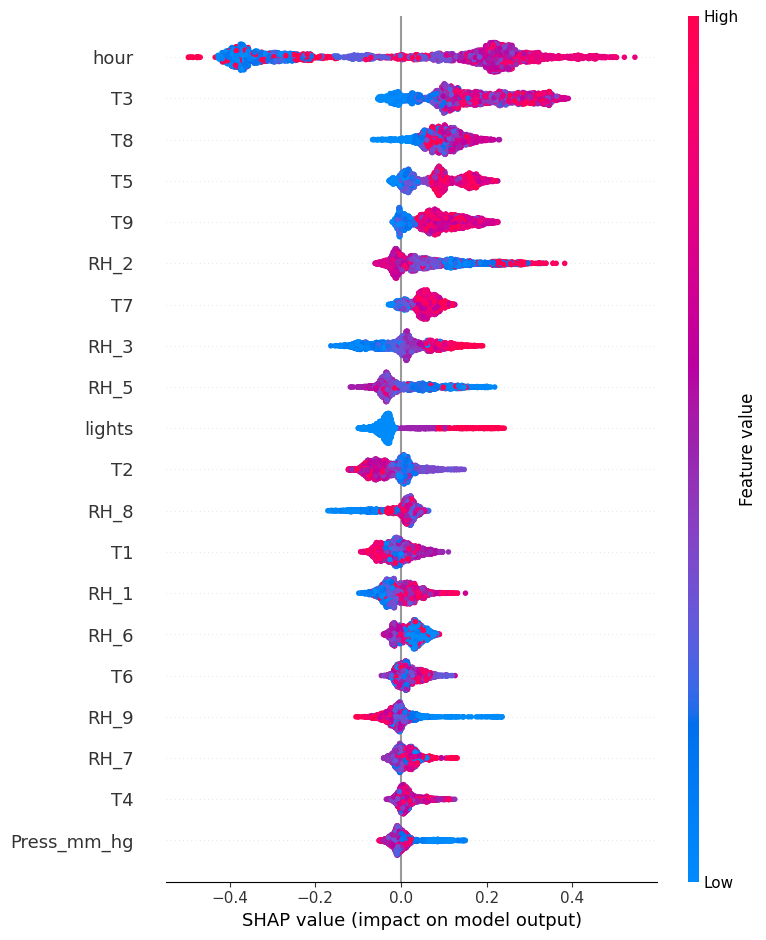

In [18]:
shap.summary_plot(shap_values, X_test)


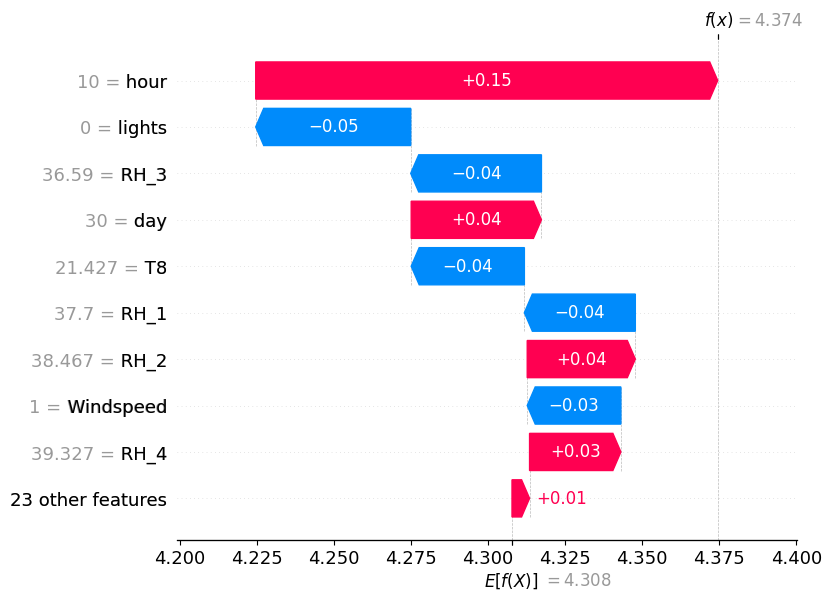

In [19]:
i = 10
shap.plots.waterfall(shap.Explanation(values=shap_values[i],
                                      base_values=explainer.expected_value,
                                      data=X_test.iloc[i],
                                      feature_names=X_test.columns))
-

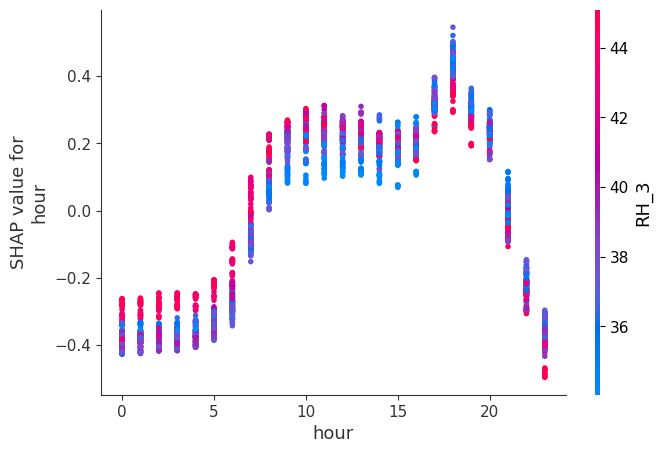

In [27]:
shap.dependence_plot("hour", shap_values, X_test)

The SHAP dependence plot shows how the hour of the day affects predicted energy consumption. Evening hours tend to increase predictions, while nighttime hours decrease them, revealing a clear nonlinear daily usage pattern captured by the model.

## 6. Comparison of PFI and SHAP
This section compares feature importance rankings obtained using PFI and SHAP. The consistency between the two methods is analyzed to assess the reliability of model explanations.



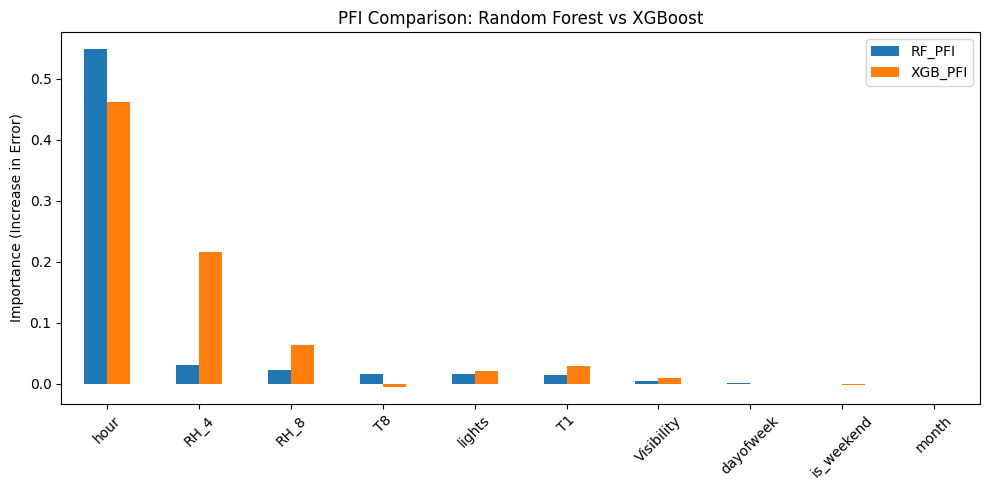

In [20]:
top_features = rf_importances.head(10).index

comparison_df = pd.DataFrame({
    "RF_PFI": rf_importances[top_features],
    "XGB_PFI": xgb_importances[top_features]
})

comparison_df.plot(kind="bar", figsize=(10,5))
plt.title("PFI Comparison: Random Forest vs XGBoost")
plt.ylabel("Importance (Increase in Error)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This plot compares permutation feature importance between Random Forest and XGBoost. Both models identify the hour of the day as the most influential variable, indicating strong daily patterns in energy consumption. Indoor environmental variables also contribute to the predictions, while calendar-based features have minimal impact.

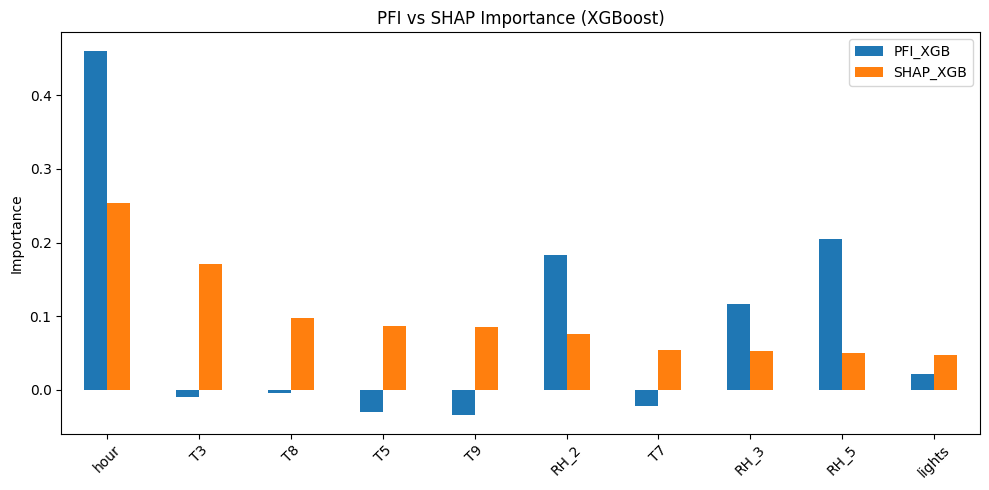

In [21]:
shap_importance = np.abs(shap_values).mean(axis=0)
shap_series = pd.Series(shap_importance, index=X_test.columns)

top_features = shap_series.sort_values(ascending=False).head(10).index

compare_explain = pd.DataFrame({
    "PFI_XGB": xgb_importances[top_features],
    "SHAP_XGB": shap_series[top_features]
})

compare_explain.plot(kind="bar", figsize=(10,5))
plt.title("PFI vs SHAP Importance (XGBoost)")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This figure compares feature importance obtained using PFI and SHAP for the XGBoost model. Both methods consistently highlight the hour of the day and indoor environmental variables as key drivers of predictions. The general agreement between the two approaches increases confidence in the reliability of the explanations.

## 7. Error Analysis
Prediction errors are analyzed to understand where the model performs well and where it struggles, particularly in predicting rare high-consumption events.


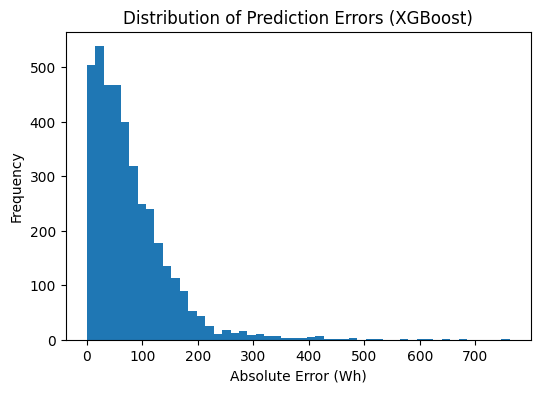

In [28]:
errors = np.abs(np.expm1(y_test_log) - pred_xgb)

plt.figure(figsize=(6,4))
plt.hist(errors, bins=50)
plt.title("Distribution of Prediction Errors (XGBoost)")
plt.xlabel("Absolute Error (Wh)")
plt.ylabel("Frequency")
plt.show()


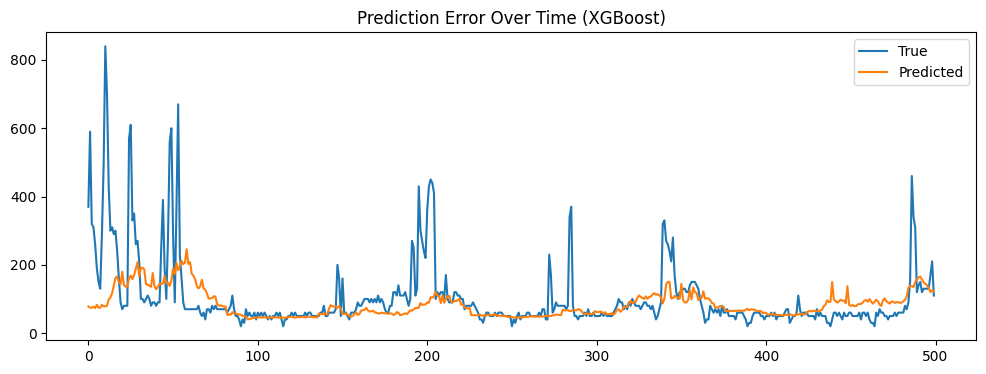

In [29]:
plt.figure(figsize=(12,4))
plt.plot(np.expm1(y_test_log.values[:500]), label="True")
plt.plot(pred_xgb[:500], label="Predicted")
plt.title("Prediction Error Over Time (XGBoost)")
plt.legend()
plt.show()


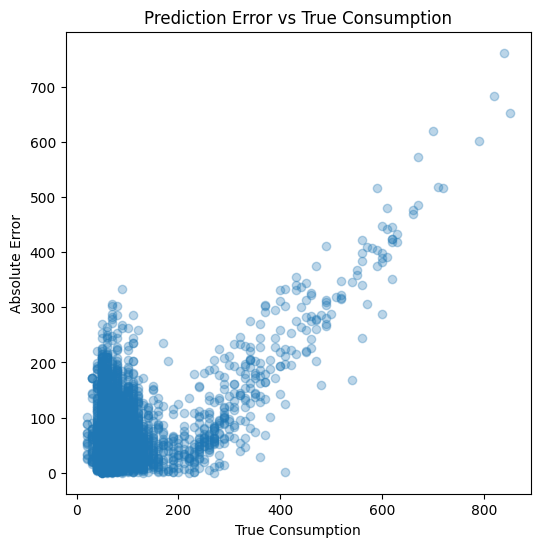

In [30]:
plt.figure(figsize=(6,6))
plt.scatter(np.expm1(y_test_log), errors, alpha=0.3)
plt.xlabel("True Consumption")
plt.ylabel("Absolute Error")
plt.title("Prediction Error vs True Consumption")
plt.show()


The error analysis shows that most prediction errors are moderate, while a small number of large errors correspond to rare high-consumption events. The model follows general consumption trends over time but struggles with sudden spikes, which are difficult to predict due to their irregular nature.

## 9. Conclusion


This project investigated explainability techniques for machine learning models predicting household appliance energy consumption. Two tree-based regression models, Random Forest and XGBoost, were trained using a time-aware data split and a log-transformed target variable to address the strong skewness in the data. Although predictive performance remained moderate due to the noisy and irregular nature of energy consumption patterns, the models were sufficiently accurate for interpretability analysis.

The main focus of the study was the comparison between Permutation Feature Importance (PFI) and SHAP explanations. Both methods consistently identified the hour of the day and indoor environmental variables as the most influential factors in the prediction process. This agreement between methods increases confidence in the reliability of the explanations. SHAP further provided detailed local explanations, showing how individual features increased or decreased specific predictions.

Overall, the project demonstrates that even when prediction accuracy is limited, explainability methods can provide meaningful insights into model behavior. These insights help build transparency and trust in machine learning systems by revealing how models use different features to make decisions.